In [1]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")

C:\Users\rusha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the datasets
df1 = pd.read_csv('Transactional_data_retail_01.csv')
df2 = pd.read_csv('Transactional_data_retail_02.csv')
df_customer = pd.read_csv('CustomerDemographics.csv')
df_product = pd.read_csv('ProductInfo.csv')

# Merge the transactional data
transactional_data = pd.concat([df1, df2])

# Convert dates to proper format
transactional_data['InvoiceDate'] = pd.to_datetime(transactional_data['InvoiceDate'], format='%d-%m-%Y', errors='coerce')
# Data Summary
print(transactional_data.info())
print(transactional_data.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Quantity     1067371 non-null  int64         
 3   Price        1067371 non-null  float64       
 4   Customer ID  824364 non-null   float64       
 5   InvoiceDate  541910 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 57.0+ MB
None
           Quantity         Price    Customer ID  \
count  1.067371e+06  1.067371e+06  824364.000000   
mean   9.938898e+00  4.649388e+00   15324.638504   
min   -8.099500e+04 -5.359436e+04   12346.000000   
25%    1.000000e+00  1.250000e+00   13975.000000   
50%    3.000000e+00  2.100000e+00   15255.000000   
75%    1.000000e+01  4.150000e+00   16797.000000   
max    8.099500e+04  3.897000e+04  

In [4]:
# Handle negative values: Remove rows with negative Quantity or Price
transactional_data = transactional_data[(transactional_data['Quantity'] > 0) & (transactional_data['Price'] > 0)]

# Handle missing values in 'Customer ID' - Drop rows with missing Customer ID
transactional_data.dropna(subset=['Customer ID'], inplace=True)

# Feature Engineering: Create Year, Month, and DayOfWeek features
transactional_data['Year'] = transactional_data['InvoiceDate'].dt.year
transactional_data['Month'] = transactional_data['InvoiceDate'].dt.month
transactional_data['DayOfWeek'] = transactional_data['InvoiceDate'].dt.dayofweek

# Identifying top 10 best-selling products by quantity sold
top_10_products = transactional_data.groupby('StockCode')['Quantity'].sum().nlargest(10).index
top_10_data = transactional_data[transactional_data['StockCode'].isin(top_10_products)]

# Aggregating sales data for time series analysis
top_10_data = top_10_data.groupby(['InvoiceDate', 'StockCode']).agg({
    'Quantity': 'sum',
    'Price': 'mean'
}).reset_index()

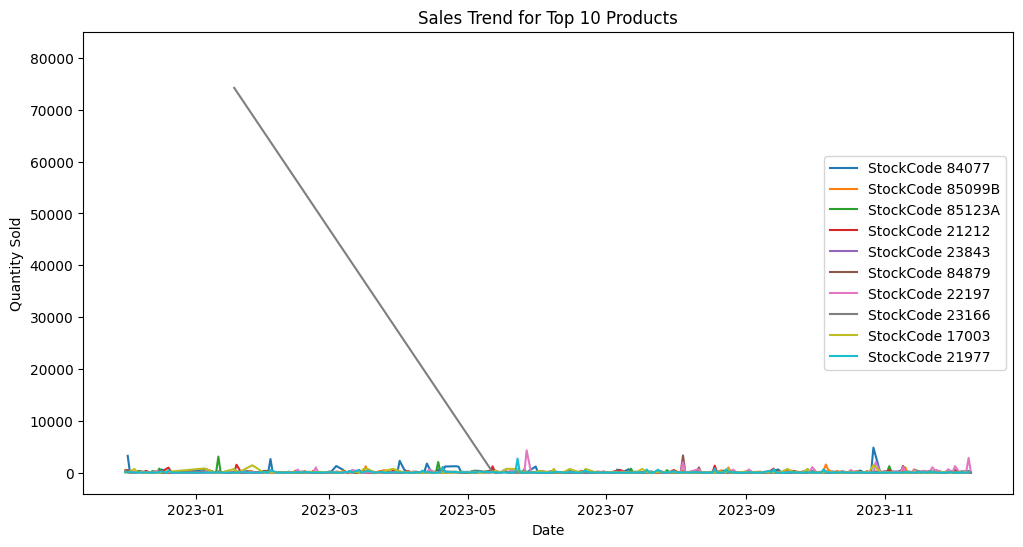

In [5]:
# Exploratory Data Analysis (EDA) - Plot sales trends for the top 10 products
plt.figure(figsize=(12, 6))
for stock_code in top_10_products:
    product_data = top_10_data[top_10_data['StockCode'] == stock_code]
    plt.plot(product_data['InvoiceDate'], product_data['Quantity'], label=f'StockCode {stock_code}')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title('Sales Trend for Top 10 Products')
plt.legend()
plt.show()

In [6]:
# Train-Test Split for Time Series Forecasting
top_10_data.set_index('InvoiceDate', inplace=True)

# Split the data into train and test sets (e.g., 80% train, 20% test)
train_data, test_data = train_test_split(top_10_data, test_size=0.2, shuffle=False)

In [8]:
# Time Series Forecasting using Prophet for each product

# Prophet expects a DataFrame with columns ['ds', 'y']
forecasts = {}
for stock_code in top_10_products:
    product_data = top_10_data[top_10_data['StockCode'] == stock_code]
    prophet_df = product_data.reset_index()[['InvoiceDate', 'Quantity']]
    prophet_df.columns = ['ds', 'y']  # Prophet needs 'ds' for the date and 'y' for the target
    
    # Check if there are at least 2 non-NaN rows
    if prophet_df['y'].notnull().sum() < 2:
        print(f"Skipping StockCode {stock_code}: Not enough data for Prophet.")
        continue
    
    # Initialize and train the model
    model = Prophet()
    model.fit(prophet_df)
    
    # Create a DataFrame for future dates (15 weeks forecast)
    future = model.make_future_dataframe(periods=15, freq='W')
    
    # Generate the forecast
    forecast = model.predict(future)
    
    # Store the forecast
    forecasts[stock_code] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

21:37:42 - cmdstanpy - INFO - Chain [1] start processing
21:37:42 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:43 - cmdstanpy - INFO - Chain [1] done processing


Skipping StockCode 23843: Not enough data for Prophet.


21:37:44 - cmdstanpy - INFO - Chain [1] start processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:44 - cmdstanpy - INFO - Chain [1] start processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:44 - cmdstanpy - INFO - Chain [1] start processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing


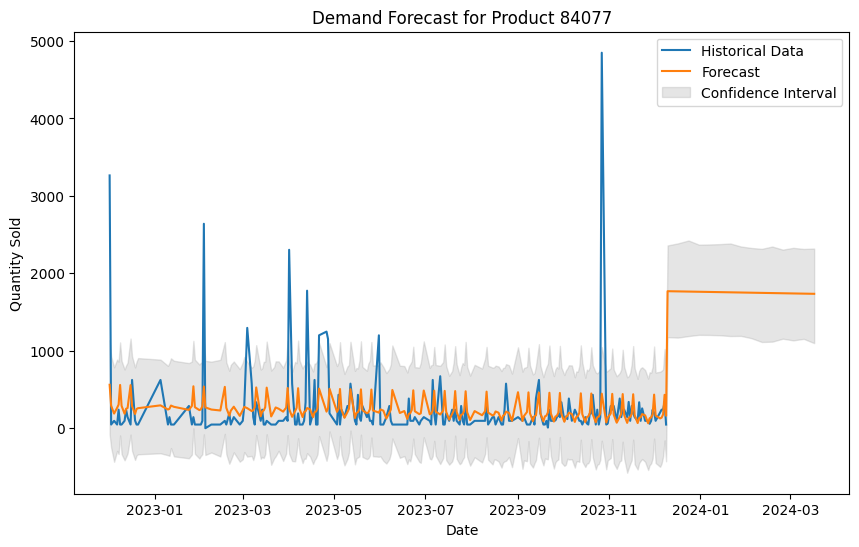

In [9]:
# Visualize the forecast for one of the top products (if available)
if forecasts:
    product_code = list(forecasts.keys())[0]  # Choose the first product with valid data
    forecast = forecasts[product_code]

    # Plot the historical and forecasted values
    plt.figure(figsize=(10, 6))
    plt.plot(top_10_data[top_10_data['StockCode'] == product_code].index, top_10_data[top_10_data['StockCode'] == product_code]['Quantity'], label='Historical Data')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.title(f'Demand Forecast for Product {product_code}')
    plt.legend()
    plt.show()

In [10]:
# Error Metrics Calculation (if there is valid forecast data)
if product_code in test_data['StockCode'].values:
    test_forecast = forecast[forecast['ds'].isin(test_data.index)]
    y_true = test_data[test_data['StockCode'] == product_code]['Quantity']
    y_pred = test_forecast['yhat']

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    print(f'RMSE for {product_code}: {rmse}')
    print(f'MAE for {product_code}: {mae}')

RMSE for 84077: 635.6711957381968
MAE for 84077: 190.44457082698813
